# Project 1

[This dataset](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Proj1.csv) is adapted from the World Health Organization on Strokes (it's based on real data but is NOT REAL). Use this dataset to answer the following questions and perform the following tasks. Feel free to add extra cells as needed, but <strong>clearly identify where each question is answered, both the code and Markdown cells</strong>. Please remove any superflous code. Please put any written/typed responses in MARKDOWN CELLS.

## Data Information

- `reg_to_vote`: 0 if no, 1 if yes.
- `age`: age of the patient in years.
- `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension.
- `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease.
- `ever_married`: 0 if no, 1 if yes.
- `Residence_type`: 0 for Rural, 1 for Urban.
- `avg_glucose_level`: average glucose level in blood.
- `bmi`: body mass index.
- `smoking_status_smokes`, `smoking_status_formerly`: Whether or not the person smokes, or formerly smoked. If a person has 0's for both these columns, they never smoked.
- `stroke`: 1 if the patient had a stroke or 0 if not.
- `dog_owner`: 0 if no, 1 if yes.
- `income_in_k`: income in thousands
- `er_visits`: number of recorded Emergency Room visits in lifetime.
- `raccoons_to_fight`: number of racoons the patient belives they could fight off at once.
- `fast_food_budget_month`: amount (in US dollars) spent on fast food per month.


## Part I: Logistic Regression
Build a logistic regression model to predict whether or not someone had a `stroke` based on **all** the other variables in the dataset.

1. Count the missing data per column, and remove rows with missing data (if any).
2. Use 10 fold cross validation for your model validation. Z-score your continuous/interval variables only. Store both the train and test accuracies to check for overfitting. **Is the model overfit? How can you tell?**
3. After completing steps 1-2, fit another logistic regression model on ALL of the data (no model validation; but do z score) using the same predictors as before, and put the coefficients into a dataframe called `coef`.
4. print out a confusion matrix for the model you made in part 3. **What does this confusion matrix tell you about your model? How can you tell?**

## Part II: Data Exploration
The WHO has asked the following five questions, create **at least 1 ggplot graph per question** (using the above data + model when needed) to help answer each question, and **explicitly answer the question in a Markdown cell** below your graph. You may use other calculations to help support your answer but MUST pair it with a graph. Write your answer as if you were explaining it to a non-data scientist. You will be graded on the effectiveness and clarity of your graph, as well as the completeness, clarity, and correctness of your responses and justifications.

1. In this specific data set, do dog-owners over 50 have a higher average probability of stoke than non-dog owners who currently smoke? How can you tell? (Do not use the model for this question, it's asking you to compare the observed probability of having a stroke in the two groups described).
2. What is the relationship between average blood glucose and BMI? Is the relationship between those two variables different for people who are and are not registered to vote? How can you tell?
3. Is your logistic regression model most accurate for people who make less than 30k, between 30-90k, or over 90k? Discuss the potential accuracy *and* ethical implications if your model *were* more accurate for different groups (you can use the full model from part I-3 to check accuracy for each of these groups; DO NOT create/fit new models for each income range, use the model from part I-3 to calculate the accuracy for each of these groups.)
4. Which of the following variables is the strongest predictor of having a stroke (owning a dog, residence type, marriage, being registered to vote)? How were you able to tell?
5. Create a variable `er_visits_per_year` that calculates the # of visits to the ER that a person has had per year of life. Store this variable in your data frame (no need to include this variable in the previous logistic regression model). Is the # of ER visits per year different for stroke and non-stroke patients? How can you tell?

In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics

In [2]:
# data
DF = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Proj1.csv")

DF.head()

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,smoking_status_smokes,smoking_status_formerly,reg_to_vote,dog_owner,raccoons_to_fight,fast_food_budget_month,income_in_k,er_visits
0,60.0,1.0,0.0,0.0,1.0,73.00,25.2,0,1,0,1.0,1.0,10.0,209.19,51.553645,9.0
1,4.0,0.0,0.0,0.0,0.0,110.15,17.1,0,0,0,0.0,1.0,13.0,176.46,45.405414,5.0
2,77.0,0.0,0.0,1.0,1.0,68.38,27.8,0,0,0,0.0,1.0,6.0,213.00,94.865174,8.0
3,37.0,0.0,0.0,1.0,1.0,95.08,30.1,0,0,0,1.0,1.0,12.0,161.90,84.123775,8.0
4,44.0,0.0,0.0,0.0,0.0,103.78,40.9,0,1,0,1.0,1.0,11.0,261.29,74.794596,11.0


# Part 1: Logistic Regression

# 1.

In [3]:
# count missing data

DF.isnull().sum()

age                         13
hypertension                12
heart_disease               21
ever_married                 9
Residence_type              21
avg_glucose_level           31
bmi                        575
stroke                       0
smoking_status_smokes        0
smoking_status_formerly      0
reg_to_vote                 14
dog_owner                   21
raccoons_to_fight           27
fast_food_budget_month       8
income_in_k                 21
er_visits                   15
dtype: int64

In [4]:
# drop the missing data

DF = DF.dropna()
DF.isnull().sum()

age                        0
hypertension               0
heart_disease              0
ever_married               0
Residence_type             0
avg_glucose_level          0
bmi                        0
stroke                     0
smoking_status_smokes      0
smoking_status_formerly    0
reg_to_vote                0
dog_owner                  0
raccoons_to_fight          0
fast_food_budget_month     0
income_in_k                0
er_visits                  0
dtype: int64

# 2. 

In [5]:
 # Split Data
predictors = ["age", "hypertension", "heart_disease", "ever_married", 
              "Residence_type", "avg_glucose_level", "bmi", "smoking_status_smokes", 
              "smoking_status_formerly", "reg_to_vote", "dog_owner", 
              "raccoons_to_fight", "fast_food_budget_month", "income_in_k", "er_visits"]

# zscore for continuous/interval variables only
continuous_interval = ["age", "avg_glucose_level", "bmi", "raccoons_to_fight", 
                       "fast_food_budget_month", "income_in_k", "er_visits"]

In [6]:
# Kfold

X = DF[predictors]
y = DF["stroke"]

# create k-fold object
kf = KFold(n_splits = 10)
kf.split(X)

# create model
lr = LogisticRegression() 

#create empty list to store accuracy for each fold
acc_train = [] 
acc_test = []

In [7]:
# Use a for loop to loop through each fold and train a model, 
# then add the accuracy to acc.

for train_indices, test_indices in kf.split(X):
    # Get your train/test for this fold
    X_train = X.iloc[train_indices]
    X_test  = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test  = y.iloc[test_indices]
    
    # z
    zscore = StandardScaler()
    zscore.fit(X_train)
    Xz_train = zscore.transform(X_train)
    Xz_test = zscore.transform(X_test)

    # model
    model = lr.fit(X_train, y_train)
    # record accuracy
    acc_train.append(accuracy_score(y_train, model.predict(X_train)))
    acc_test.append(accuracy_score(y_test, model.predict(X_test)))

In [8]:
np.mean(acc_train)

0.9582806029767952

In [9]:
np.mean(acc_test)

0.9583047443397745

This model is not overfitting; the train and tset set are similar. When the model has a low error rate in training data but a high error rate in testing data, we can say the model is overfitting

# 3. 

In [10]:
X = DF[predictors]
y = DF["stroke"]

X[continuous_interval] = zscore.fit_transform(X[continuous_interval])

lr = LogisticRegression() 
lr.fit(X, y)

LogisticRegression()

In [11]:
coef = pd.DataFrame({"Coefs": lr.coef_[0],
                     "Names": predictors})
coef

,Coefs,Names
0,1.613121,age
1,0.249543,hypertension
2,0.423396,heart_disease
3,-0.187965,ever_married
4,-0.019790,Residence_type
5,0.242798,avg_glucose_level
6,0.111694,bmi
7,0.294617,smoking_status_smokes
8,0.145672,smoking_status_formerly
9,-0.059925,reg_to_vote


# 4.

Text(0.5, 1.0, 'Confusion matrix of the classifier')

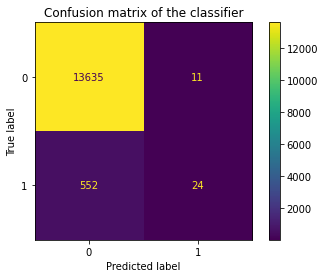

In [12]:
plot_confusion_matrix(lr, X, y)
plt.title('Confusion matrix of the classifier')

 This confusion matrix tells the accuracy of the model between two variables. 
 There are high accuracy of 13635 where the patients did not have a stroke and were predicted not to have a stroke (top left). This indicates that the prediction is strongly supported. 

# Part 2: Data Exploration

# 1. 

In [13]:
# Probability of dog owners over 50 having a stroke
dog50 = (DF["dog_owner"] == 1) & (DF["age"] > 50)
dog50_mean = DF.loc[dog50, "stroke"].mean()

print("The probability of dog owners over 50 having a stroke is ", dog50_mean)

The probability of dog owners over 50 having a stroke is  0.08617290903970712


In [14]:
# Probability of non dog owners who currently smoke having a stroke
nonDogSmoke = (DF["dog_owner"] == 0) & (DF["smoking_status_smokes"] == 1)
nonDogSmoke_mean = DF.loc[nonDogSmoke, "stroke"].mean()

print("The probability of non dog owners who currently smoke having a stroke is ", nonDogSmoke_mean)

The probability of non dog owners who currently smoke having a stroke is  0.0387409200968523


In [15]:
category = ["Dog Owners over 50", "Non Dog Owners who currently smoke"]
Prob = [dog50_mean, nonDogSmoke_mean]

DF1 = pd.DataFrame({"Name": category, "Probability": Prob})

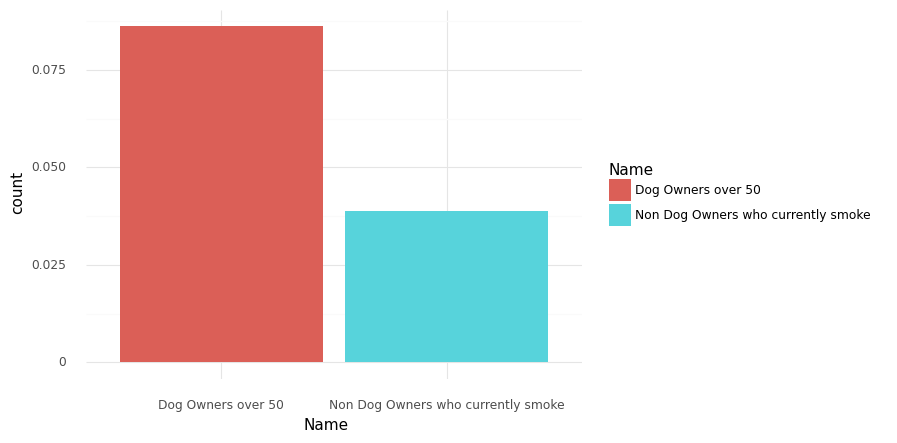

<ggplot: (327838642)>

In [16]:
# ggplot
(ggplot(DF1, aes(x = "Name", weight = "Probability", fill = "Name")) 
+ geom_bar() + theme_minimal()) 

Dog owner over 50 has a twice greater probability of having a stroke compared to non dog owners who currently smoke. Therefore, dog owner over 50 has a higher average probability of stroke than non-dog owners who currently smoke. 

# 2.

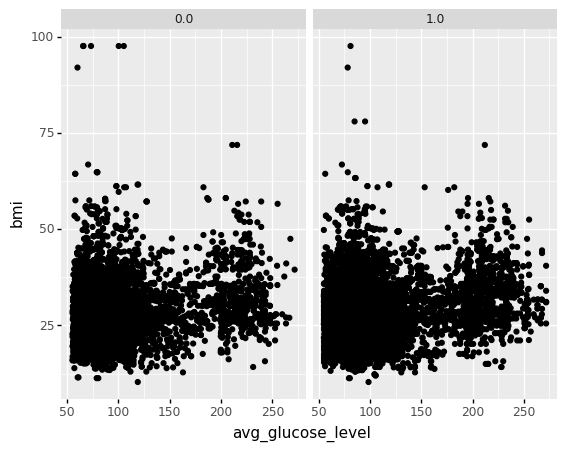

<ggplot: (327920680)>

In [17]:
# ggplot
(ggplot(DF, aes(x = "avg_glucose_level", y = "bmi")) + geom_point() 
+ facet_wrap("~reg_to_vote"))

The relationships between aveage blood glucose and BMI for people who are registered to vote and are not registered to vote have no significant differences. Therefore, the registration to vote does not have a significant relationship to average blood glucose and BMI. 

# 3.

In [18]:
# less than 30k
less_30k = DF["income_in_k"] < 30
df1 = DF.loc[less_30k]
X = df1[predictors]
y = df1["stroke"]
X[continuous_interval] = zscore.fit_transform(X[continuous_interval])
ac1 = accuracy_score(y, lr.predict(X))
ac1

1.0

In [19]:
# between 30 to 90k 
btn_30to90k = (DF["income_in_k"] > 30) & (DF["income_in_k"] < 90)
df2 = DF.loc[btn_30to90k]
X = df2[predictors]
y = df2["stroke"]
X[continuous_interval] = zscore.fit_transform(X[continuous_interval])
ac2 = accuracy_score(y, lr.predict(X))
ac2

0.9613199891804165

In [20]:
# over 90k
over_90k = DF["income_in_k"] > 90
df3 = DF.loc[over_90k]
X = df3[predictors]
y = df3["stroke"]
X[continuous_interval] = zscore.fit_transform(X[continuous_interval])
ac3 = accuracy_score(y, lr.predict(X))
ac3

0.9540428472702143

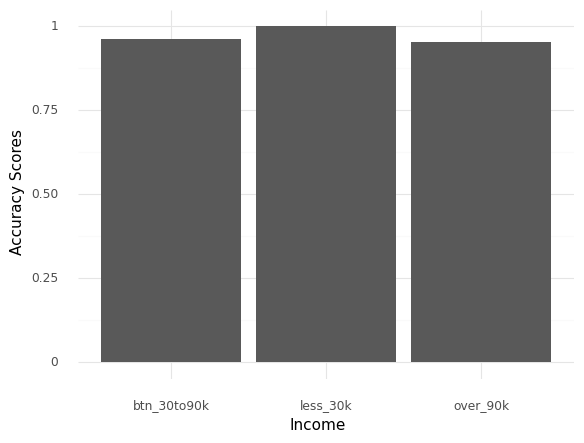

<ggplot: (327585112)>

In [21]:
income = ["less_30k", "btn_30to90k", "over_90k"]
accuracy = [ac1, ac2, ac3]
df_accuracy = pd.DataFrame({"Income": income, 
                            "Accuracy Scores": accuracy})

# ggplot
(ggplot(df_accuracy, aes(x = "Income", 
                         y = "Accuracy Scores")) 
+ stat_summary(geom = "bar") + theme_minimal()) 

Based on the accuracy score, people who make less than 30k has the most accurate logistic. The accuracy score was 1.0 which is suspicious but can be possibly caused by small amount of data (overfit). Income between 30 to 90k has the accuracy of 0.961 and over 90k has the accuracy of 0.954 which are also highly accurate. Therefore, it's hard to determine the most accurate logistic accuracy where all three variables have the high accuracy scores. 

# 4. 

In [22]:
variables = (coef["Names"] == "dog_owner") | (coef["Names"] == "Residence_type") | (coef["Names"] == "ever_married") | (coef["Names"] == "reg_to_vote")

coef2 = coef.loc[variables]
coef2

,Coefs,Names
3,-0.187965,ever_married
4,-0.019790,Residence_type
9,-0.059925,reg_to_vote
10,0.015419,dog_owner


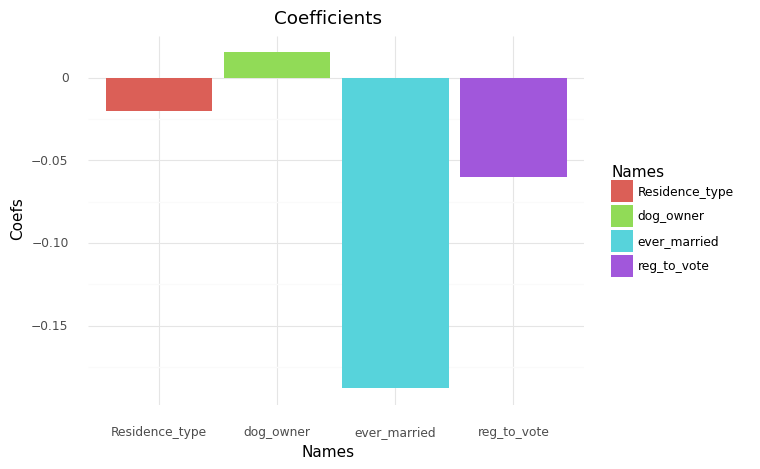

<ggplot: (328220624)>

In [23]:
# ggplot
(ggplot(coef2, aes(x = "Names", y = "Coefs", fill = "Names"))  
+ theme_minimal() + geom_bar(stat = "identity") + ggtitle("Coefficients"))

Between variables, marraige had the strongest predictor of having a stroke which had the greatest coefficient compared to other variables. As ever_married unit increases by 1, the coefficient decreases by 0.188 which is the greatest among the variables. 

# 5.

In [24]:
DF["er_visits_per_year"] = DF["er_visits"]/DF["age"]
DF

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,smoking_status_smokes,smoking_status_formerly,reg_to_vote,dog_owner,raccoons_to_fight,fast_food_budget_month,income_in_k,er_visits,er_visits_per_year
0,60.0,1.0,0.0,0.0,1.0,73.00,25.2,0,1,0,1.0,1.0,10.0,209.19,51.553645,9.0,0.150000
1,4.0,0.0,0.0,0.0,0.0,110.15,17.1,0,0,0,0.0,1.0,13.0,176.46,45.405414,5.0,1.250000
2,77.0,0.0,0.0,1.0,1.0,68.38,27.8,0,0,0,0.0,1.0,6.0,213.00,94.865174,8.0,0.103896
3,37.0,0.0,0.0,1.0,1.0,95.08,30.1,0,0,0,1.0,1.0,12.0,161.90,84.123775,8.0,0.216216
4,44.0,0.0,0.0,0.0,0.0,103.78,40.9,0,1,0,1.0,1.0,11.0,261.29,74.794596,11.0,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,52.0,1.0,0.0,0.0,1.0,106.22,29.0,0,0,0,0.0,0.0,1.0,179.77,74.826197,9.0,0.173077
14996,56.0,0.0,0.0,1.0,1.0,63.18,26.5,0,0,0,1.0,0.0,15.0,143.61,52.280949,16.0,0.285714
14997,60.0,1.0,0.0,1.0,0.0,100.20,28.6,0,0,0,0.0,1.0,17.0,64.87,92.427118,24.0,0.400000
14998,77.0,0.0,0.0,1.0,0.0,90.00,32.0,0,0,0,0.0,0.0,11.0,205.92,53.042139,6.0,0.077922


In [25]:
# ggplot
(ggplot(DF, aes(x = "er_visits_per_year")) + geom_histogram() 
+ facet_wrap("~stroke") + xlim(0,10))

ValueError: cannot convert float NaN to integer

The number of visits to the ER was higher for non-stroke patients than the stroke patients. Non-stroke patients had the greater number of ER visits per year compared to stroke patients' number of ER visits per year. 